In [1]:
%matplotlib inline
import re
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import hamming_loss
from sklearn.metrics import log_loss
import seaborn as sns
import nltk
from nltk.corpus import stopwords
import seaborn as sns
from nltk.stem.porter import *
stemmer = PorterStemmer()

# Data Loading

In [2]:
df = pd.read_csv("jigsaw-toxic-comment-classification-challenge/train.csv", encoding = "ISO-8859-1")

# Data Visualisation

The below graph shows number of comments in each classes. Data for 'toxic' label is more.

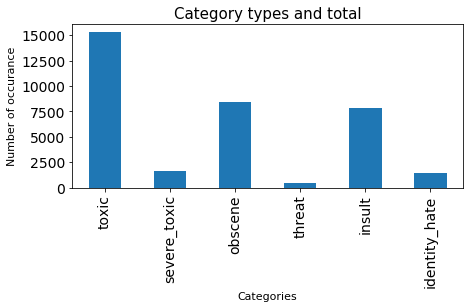

In [3]:
category_sum = (df.groupby('id').sum()).sum()
category_sum.plot(kind='bar',label='label',figsize=(7,3))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Category types and total',fontsize=15)
plt.ylabel('Number of occurance',fontsize=11)
plt.xlabel('Categories',fontsize=11)
plt.show()

In [4]:
eachrow = df.iloc[:,2:].sum(axis=1)
x=eachrow.value_counts()
x

0    143346
1      6360
3      4209
2      3480
4      1760
5       385
6        31
dtype: int64

##### The bar chart of 'Multiple category status' shows, the number of labels of each comment. It clearly visible that comments with more labels are higher

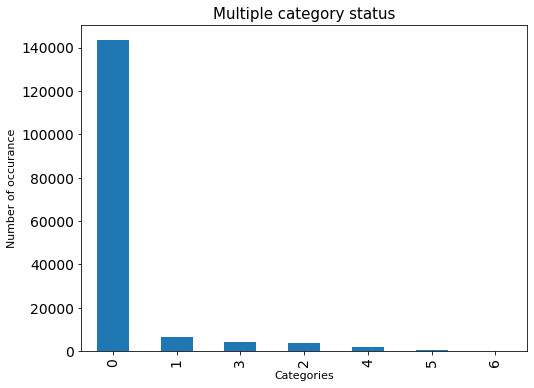

In [5]:
eachrow = df.iloc[:,2:].sum(axis=1)
x=eachrow.value_counts()
x.plot(kind='bar',label='label',figsize=(8,6))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Multiple category status',fontsize=15)
plt.ylabel('Number of occurance',fontsize=11)
plt.xlabel('Categories',fontsize=11)
plt.show()

# Data Preprocessing

In [6]:
replace_dict={"what's" : "what is" , "\'s" : " " , "\'ve" : " have " , "can't" : "can not " , "n't" : " not " , "i'm" : "i am " , "\'re" : " are " , "\'d" : " would " , "\'ll" : " will " , "\'scuse" : " excuse", '\'' : " ", ',' : " ", '&' : " ", '#' : " ", '%' : " ", "*" : " ", "(" : " ", ")" : " ", "!" : " "}
def clean_text(text):
    text = text.lower()
    for key,values in replace_dict.items():
        text=text.replace(key,values)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text
def cleanHtml(sentence):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(sentence))
    return cleantext
def stemming(sentence):
    stemSentence = ""
    for word in sentence.split():
        stem = stemmer.stem(word)
        stemSentence += stem
        stemSentence += " "
    stemSentence = stemSentence.strip()
    return stemSentence

In [7]:
df['comment_text'] = df['comment_text'].map(lambda com : clean_text(com))
df['comment_text'] = df['comment_text'].apply(cleanHtml)


In [8]:
import sys
sys.setrecursionlimit(10000)
df['comment_text'] = df['comment_text'].apply(stemming)

Make the data into normalize format by converting to lower and replace short forms and punctuations. Then remove the html tags. Keep the text in comments in stemmed format. Utilize the NLTK porter stemmer to stem the data.

In [9]:
no_comment_df=df[(df['toxic']==0) & (df['severe_toxic']==0) & (df['obscene']==0) & (df['threat']== 0) & (df['insult']==0) & (df['identity_hate']==0)]

In [10]:
comment_df=df[~df.index.isin(no_comment_df.index)]

In [11]:
newdf=pd.concat([no_comment_df[:100000],comment_df])

# Split and vectorize the data

Split the data using train_test_split and vectorize using 'TfidfVectorizer'.

In [12]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words,max_features=10000)
train, val = train_test_split(newdf,test_size=0.2, random_state=49)

In [13]:
xtrain=train['comment_text']
xval=val['comment_text']
tfidf_vectorizer.fit(xtrain)
tfidf_vectorizer.fit(xval)
xtrain_tfidf=tfidf_vectorizer.transform(xtrain)
xval_tfidf = tfidf_vectorizer.transform(xval)

In [14]:
y_train = train.drop(labels = ['id','comment_text'], axis=1)
y_test = val.drop(labels = ['id','comment_text'], axis=1)

# 1. Model with OneVsRestClassifier with LogisticRegression

In [15]:
lr = LogisticRegression(solver='sag')
clf = OneVsRestClassifier(lr,n_jobs=-1)

In [16]:
clf.fit(xtrain_tfidf, y_train)

OneVsRestClassifier(estimator=LogisticRegression(C=1.0, class_weight=None,
                                                 dual=False, fit_intercept=True,
                                                 intercept_scaling=1,
                                                 l1_ratio=None, max_iter=100,
                                                 multi_class='warn',
                                                 n_jobs=None, penalty='l2',
                                                 random_state=None,
                                                 solver='sag', tol=0.0001,
                                                 verbose=0, warm_start=False),
                    n_jobs=-1)

In [17]:
def evaluation(Y_test,predict): 
    loss = hamming_loss(Y_test,predict)
    print("Hamming_loss : {}".format(loss*100))
    accuracy = accuracy_score(Y_test,predict)
    print("Accuracy : {}".format(accuracy*100))
    try : 
        loss = log_loss(Y_test,predict)
    except :
        loss = log_loss(Y_test,predict.toarray())
    print("Log_loss : {}".format(loss))

## Evaluated for whole train data

In [18]:
predicted=clf.predict(xval_tfidf)
evaluation(y_test,predicted)

Hamming_loss : 2.5475012547501255
Accuracy : 89.1159389115939
Log_loss : 2.077803333559048


In [19]:
categories = list(df.columns.values)
categories = categories[2:]

## Evaluated for categorical data

In [20]:
for category in categories:
#     print('**Processing {} comments...**'.format(category))
    categorical_lr = OneVsRestClassifier(lr,n_jobs=-1)
    # Training the model
    categorical_lr.fit(xtrain_tfidf, train[category])
    # Test accuracy 
    prediction = categorical_lr.predict(xval_tfidf)
    print('Test accuracy of {} is {}'.format(category,accuracy_score(val[category], prediction)))

Test accuracy of toxic is 0.9446762744676275
Test accuracy of severe_toxic is 0.9870939987093998
Test accuracy of obscene is 0.9694127769412777
Test accuracy of threat is 0.9953968595396859
Test accuracy of insult is 0.9603785760378576
Test accuracy of identity_hate is 0.9901914390191439


# 2. Model with OneVsRestClassifier with LinearSVC

In [21]:
one_clf=OneVsRestClassifier(LinearSVC(), n_jobs=1)
one_clf.fit(xtrain_tfidf, y_train)

OneVsRestClassifier(estimator=LinearSVC(C=1.0, class_weight=None, dual=True,
                                        fit_intercept=True, intercept_scaling=1,
                                        loss='squared_hinge', max_iter=1000,
                                        multi_class='ovr', penalty='l2',
                                        random_state=None, tol=0.0001,
                                        verbose=0),
                    n_jobs=1)

## Evaluation of model on whole data

In [22]:
one_predict=one_clf.predict(xval_tfidf)
evaluation(y_test,one_predict)

Hamming_loss : 2.510217251021725
Accuracy : 88.8707248870725
Log_loss : 2.1052914656048602


## Evaluation of model on categorical data

In [23]:
for category in categories:
    #print('**Processing {} comments...**'.format(category))
    categorical_svc = OneVsRestClassifier(LinearSVC(),n_jobs=-1)
    # Training LinearSVC model 
    categorical_svc.fit(xtrain_tfidf, train[category])
    # Test accuracy
    prediction = categorical_svc.predict(xval_tfidf)
    print('Test accuracy of {} is {}'.format(category,accuracy_score(val[category], prediction)))

Test accuracy of toxic is 0.9465261346526135
Test accuracy of severe_toxic is 0.9866637986663799
Test accuracy of obscene is 0.9707894170789417
Test accuracy of threat is 0.9952247795224779
Test accuracy of insult is 0.9599053559905356
Test accuracy of identity_hate is 0.9902774790277479


In [24]:
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.svm import SVC
classifier = BinaryRelevance(classifier = SVC(), require_dense = [False, True])
classifier.fit(xtrain_tfidf, y_train)

/home/akilesh/test_data/env/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/akilesh/test_data/env/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/akilesh/test_data/env/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/akilesh/test_data/env/lib/python3.

BinaryRelevance(classifier=SVC(C=1.0, cache_size=200, class_weight=None,
                               coef0=0.0, decision_function_shape='ovr',
                               degree=3, gamma='auto_deprecated', kernel='rbf',
                               max_iter=-1, probability=False,
                               random_state=None, shrinking=True, tol=0.001,
                               verbose=False),
                require_dense=[False, True])

In [25]:
predictions = classifier.predict(xval_tfidf)

In [26]:
evaluation(y_test,predictions)

Hamming_loss : 5.00681150068115
Accuracy : 86.00559260055925
Log_loss : 0.5382601150191229


# Model using GRU

In [28]:
from keras.models import Model
from keras.layers import Dense, Embedding, Input, LSTM, Bidirectional, GlobalMaxPool1D, Dropout
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.
/home/akilesh/test_data/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/akilesh/test_data/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/akilesh/test_data/env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/akilesh/test_data/env/lib/python3.6

In [29]:
train_length = df.comment_text.apply(len)
train_length.head()

0    240
1     99
2    204
3    537
4     58
Name: comment_text, dtype: int64

In [30]:
vocab_len = 20000
max_len = 150
emb_size = 128

In [31]:
X = df.comment_text
y = df[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values

In [32]:
test = pd.read_csv("jigsaw-toxic-comment-classification-challenge/test.csv", encoding = "ISO-8859-1")
test = test.comment_text

In [33]:
tok = Tokenizer(num_words = vocab_len)
tok.fit_on_texts(list(X))

In [34]:
X = tok.texts_to_sequences(X)
test = tok.texts_to_sequences(test)

In [35]:
X = sequence.pad_sequences(X, maxlen = max_len)
X_test = sequence.pad_sequences(test, maxlen = max_len)

## Define layers

In [36]:
from keras.models import Sequential
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
embedding_dim = 256
model = Sequential()
model.add(Embedding(vocab_len, embedding_dim,input_length = 150))
model.add(GRU(256, dropout=0.9, return_sequences=True))
model.add(GRU(256, dropout=0.9))
model.add(Dense(6, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model.fit(X, y, validation_split=0.1, batch_size=32, epochs=3)






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 1242s 9ms/step - loss: 0.0740 - acc: 0.9758 - val_loss: 0.0536 - val_acc: 0.9814
Epoch 2/3
143613/143613 [==============================] - 1243s 9ms/step - loss: 0.0540 - acc: 0.9809 - val_loss: 0.0503 - val_acc: 0.9818
Epoch 3/3
143613/143613 [==============================] - 1242s 9ms/step - loss: 0.0516 - acc: 0.9815 - val_loss: 0.0495 - val_acc: 0.9820


# Accuracy Plot

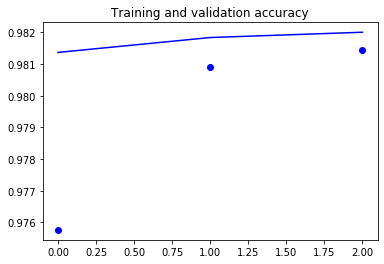

In [37]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.show()